# 🐾 AnimalCLEF2025 Competition: Official Starter notebook

The **Goal of the** [AnimalCLEF2025](https://www.kaggle.com/competitions/animal-clef-2025/) competition is to identify individual animal (lynxes, salamanders and sea turtles) in photos. This notebook visualize the provided dataset and propose a baseline solution, based on the state-of-the-art re-identification model [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384). The dataset is split into the database and query sets. For each image from the query set, the goal is to:

- Predict whether the depicted individual is in the database.
- If no, the prediction is `new_individual`.
- If yes, the prediction should be the same as the individual in the database.

## Dependencies instalation
For the competition we provide two Python packages for loading and preprocessing of available datasets ([wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets)) and tools / method for animal re-identification ([wildlife-tools](https://github.com/WildlifeDatasets/wildlife-tools)).

In [9]:
#!pip install git+https://github.com/WildlifeDatasets/wildlife-datasets@develop
#!pip install git+https://github.com/WildlifeDatasets/wildlife-tools

  Cloning https://github.com/WildlifeDatasets/wildlife-datasets (to revision develop) to /private/var/folders/jk/m2f13ljx3sjfvd1yqj017pk80000gn/T/pip-req-build-gp7olhgh
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-datasets /private/var/folders/jk/m2f13ljx3sjfvd1yqj017pk80000gn/T/pip-req-build-gp7olhgh
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  branch 'develop' set up to track 'origin/develop'.
  Resolved https://github.com/WildlifeDatasets/wildlife-datasets to commit 753d9bf64861c3e17011136b3436bf58bf02317f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/WildlifeDatasets/wildlife-tools to /private/var/folders/jk/m2f13ljx3sjfvd1yqj017pk80000gn/T/pip-req-build-_390hrxn
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/w

## Dependencies import
We load all the required packages and then define the function `create_sample_submission`, which converts provided predictions and a submission file for the competition.

In [10]:
import os
import numpy as np
import pandas as pd
import timm
import torch
import torchvision.transforms as T
from wildlife_datasets.datasets import AnimalCLEF2025
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
def create_sample_submission(dataset_query, predictions, file_name='sample_submission.csv'):
    df = pd.DataFrame({
        'image_id': dataset_query.metadata['image_id'],
        'identity': predictions
    })
    df.to_csv(file_name, index=False)

We need to specify the `root`, where the data are stored and then two image transformations. 
1. The first transform only resizes the images and is used for visualization.
2. The second transform also converts it to torch tensor and is used for operations on neural networks.

In [11]:
root = '../animal-clef-2025_data'
transform_display = T.Compose([
    T.Resize([384, 384]),
    ])
transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

### 📊 Visualizing Data

Since `AnimalCLEF2015` is the child class of `datasets.WildlifeDataset` from [wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets/blob/main/wildlife_datasets/datasets/datasets.py), it inherits all its methods and attributes. The following code specify which `transform` we want to use while loading images and that we want to load labels alongside images.

In [12]:
dataset = AnimalCLEF2025(root, transform=transform_display, load_label=True)

📌 **Plotting a sample grid** of the data. We can see that all animals in the testing sets are turtles. The column `dataset` states that all the photos come from the SeaTurtleID2022 dataset.

,image_id,identity,path,date,orientation,species,split,dataset
0,0,LynxID2025_lynx_37,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,LynxID2025_lynx_37,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,LynxID2025_lynx_49,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,3,NaN,images/LynxID2025/query/003b89301c7b9f6d18f722...,NaN,back,lynx,query,LynxID2025
4,4,LynxID2025_lynx_13,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025
...,...,...,...,...,...,...,...,...
15204,15204,NaN,images/SeaTurtleID2022/query/images/fecd2dfed0...,2024-06-07,NaN,loggerhead turtle,query,SeaTurtleID2022
15205,15205,NaN,images/SeaTurtleID2022/query/images/ff1a0c812b...,2023-06-28,NaN,loggerhead turtle,query,SeaTurtleID2022
15206,15206,NaN,images/SeaTurtleID2022/query/images/ff22f1cfa6...,2024-06-09,NaN,loggerhead turtle,query,SeaTurtleID2022
15207,15207,NaN,images/SeaTurtleID2022/query/images/ff5d5116d1...,2023-06-21,NaN,loggerhead turtle,query,SeaTurtleID2022


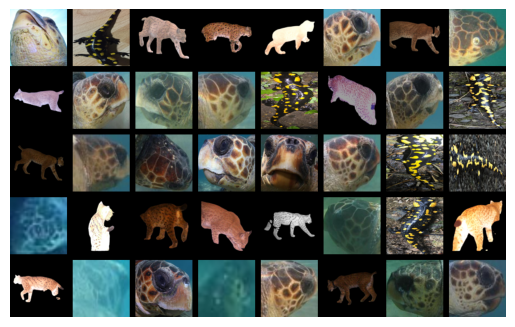

In [13]:
dataset.plot_grid()
dataset.metadata

This is confirmed by showing all datasets from which the data is composed of.

In [14]:
dataset.metadata[['dataset', 'split']].value_counts()

dataset           split   
SeaTurtleID2022   database    8729
LynxID2025        database    2957
SalamanderID2025  database    1388
LynxID2025        query        946
SalamanderID2025  query        689
SeaTurtleID2022   query        500
Name: count, dtype: int64

Now, we can plot the data of any dataset. Here we do it for the SeaTurtleID2022. The images are the same as in the query set. The goal for each image from the query set will be to determine its identity from the database (it will always be in the form `SeaTurtleID2022_t???` or to decide that it is a new individual (it is not present in the database).

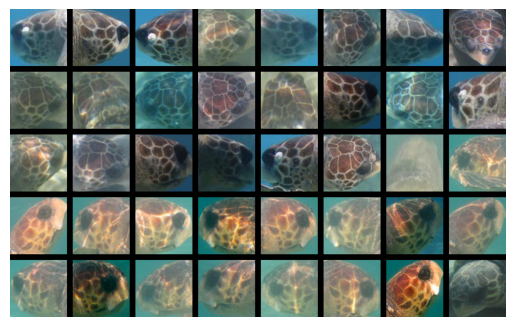

In [15]:
idx = dataset.metadata['identity'].str.startswith('SeaTurtleID2022')
idx[idx.isnull()] = False
dataset.plot_grid(idx=idx);

## Inference with MegaDescriptor

Instead of training a classifier, we can just use out of the shelf pretrained models - [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384). We use MegaDescriptor to extract features from all images. 

**Note:** _It is highly recommended to use the GPU acceleration._

In [16]:
# Loading the dataset
dataset = AnimalCLEF2025(root, transform=transform, load_label=True)
dataset_database = dataset.get_subset(dataset.metadata['split'] == 'database')
dataset_query = dataset.get_subset(dataset.metadata['split'] == 'query')
n_query = len(dataset_query)

In [18]:
# Set device, Mac, GPU, or CPU
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [19]:
#Loading the model
name = 'hf-hub:BVRA/MegaDescriptor-L-384'
#device = 'cuda'
model = timm.create_model(name, num_classes=0, pretrained=True)
extractor = DeepFeatures(model, device=device, batch_size=32, num_workers=0)
features_database = extractor(dataset_database)
features_query = extractor(dataset_query)

100%|███████████████████████████████████████████████████████████████| 67/67 [01:58<00:00,  1.77s/it]


Here we extract the similarity between the images. The similarity equals to the cosine similarity between the corresponding feature vectors. Since the cosine similarity reflects the angle between the feature vectors, high similarity means that the feature vectors are close to each other and should depict the same individual.

In [20]:
similarity = CosineSimilarity()(features_query, features_database)

For each query image we extract the closest image as predicted by MegaDescriptor. Their indices are stored in `pred_idx` and the similarity score of the top match in `pred_scores`.

In [21]:
pred_idx = similarity.argsort(axis=1)[:,-1]
pred_scores = similarity[range(n_query), pred_idx]

This is sufficient to perform predictions as shown below in `predictions`. However, we also need to predict whether the individual is new. We utilize the simplest idea and predict that the individual is new whenever the similarity score of the top prediction is below a certain threshold which we arbirtarily selected as 0.6. We create a submission file, which scores 30.0% on the public leaderboard.

In [22]:
new_individual = 'new_individual'
threshold = 0.6
labels = dataset_database.labels_string
predictions = labels[pred_idx]
predictions[pred_scores < threshold] = new_individual


In [23]:
# Doesnt work yet

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# … your existing code up to creating `predictions` …

# === EVALUATION ===

# Ground-truth IDs for each query image
gt = np.array(dataset_query.metadata['identity'])

# 1) Closed-set accuracy: only on queries whose true ID is in the database
known_mask = np.isin(gt, dataset_database.labels_string)
acc_closed = accuracy_score(gt[known_mask], predictions[known_mask])
print(f"Closed-set accuracy (known IDs): {acc_closed:.2%}")

# 2) Open-set “new individual” detection
#   - true_unknown: queries whose gt is NOT in the database
#   - pred_unknown: queries predicted as 'new_individual'
true_unknown = ~known_mask
pred_unknown = (predictions == 'new_individual')

tn, fp, fn, tp = confusion_matrix(true_unknown, pred_unknown).ravel()
print("Open-set detection:")
print(f"  Correctly flagged new (TN):    {tn}")
print(f"  Mistaken known→new (FP):        {fp}")
print(f"  Mistaken new→known (FN):        {fn}")
print(f"  Correctly matched known (TP):   {tp}")

# 3) Classification report for the known-ID queries
print("\nClassification report (known IDs):")
print(classification_report(
    gt[known_mask],
    predictions[known_mask],
    labels=dataset_database.labels_string,
    zero_division=0
))

# === (Optionally) Write out your submission ===
create_sample_submission(dataset_query, predictions, 'sample_submission.csv')

Closed-set accuracy (known IDs): nan%
Open-set detection:
  Correctly flagged new (TN):    0
  Mistaken known→new (FP):        0
  Mistaken new→known (FN):        1397
  Correctly matched known (TP):   738

Classification report (known IDs):
                      precision    recall  f1-score   support

  LynxID2025_lynx_37       0.00      0.00      0.00       0.0
  LynxID2025_lynx_37       0.00      0.00      0.00       0.0
  LynxID2025_lynx_49       0.00      0.00      0.00       0.0
  LynxID2025_lynx_13       0.00      0.00      0.00       0.0
  LynxID2025_lynx_07       0.00      0.00      0.00       0.0
  LynxID2025_lynx_95       0.00      0.00      0.00       0.0
  LynxID2025_lynx_49       0.00      0.00      0.00       0.0
  LynxID2025_lynx_32       0.00      0.00      0.00       0.0
  LynxID2025_lynx_60       0.00      0.00      0.00       0.0
  LynxID2025_lynx_24       0.00      0.00      0.00       0.0
  LynxID2025_lynx_43       0.00      0.00      0.00       0.0
  LynxID2025_

/Users/matthewjones2/anaconda3/envs/574_animal_clef_env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/matthewjones2/anaconda3/envs/574_animal_clef_env/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
create_sample_submission(dataset_query, predictions, file_name = 'Matthew_submission.csv')